## TD 2 Portfolio Allocation : Sensitivity of Markowitz & Robust Optimization

#### Exercise 1 :

In [ ]:
import numpy as np
sigma = np.array([0.143, 0.164, 0.083, 0.07])
rho = np.array([[1, 0.821, 0.285, 0.06],
               [0.821,1,0.344,0.017],
               [0.285, 0.344, 1, 0.589],
               [0.06,0.017,0.589,1]])

In [ ]:
n = len(sigma)
Sigma = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Sigma[i,j] = sigma[i]*sigma[j]*rho[i,j]

In [ ]:
# For the minimum variance portfolio :
import cvxpy as cp
w = cp.Variable(n)
objective = cp.Minimize(w.T @ Sigma @ w)

one = np.ones(n)

# Define the constraints
constraints = [
    one.T @ w == 1
]

# Define and solve the problem
prob = cp.Problem(objective, constraints)
result = prob.solve()

# Output the results
print("Optimal weights w_MVO:", w.value)
print("Minimum variance:", result)

Optimal weights w_MVO: [0.12225036 0.02869254 0.15894766 0.69010944]
Minimum variance: 0.0040044926872429675


In [ ]:
num = np.linalg.inv(Sigma) @ one
den = (one.T @ np.linalg.inv(Sigma) @ one)
w = num / den
print("Theoretical optimal weights w_MV:", w)

Theoretical optimal weights w_MV: [0.12225036 0.02869254 0.15894766 0.69010944]


In [ ]:
# For the equal risk budget portfolio :
from scipy.optimize import minimize
def risk_contribution(weights,Sigma):
  portfolio_risk = np.sqrt(weights.T @ Sigma @ weights)
  marginal_risk = Sigma @ weights
  risk_contributions = weights * marginal_risk / portfolio_risk
  return risk_contributions

def objective(weights, Sigma):
  rc = risk_contribution(weights, Sigma)
  return np.sum(rc-np.mean(rc)**2)

constraints = [{'type':'eq', 'fun': lambda w: np.sum(w)-1}]
bounds = [(0,1) for _ in range(n)] # Long-only constraints

w0 = np.ones(n) / n # Initial guess

result = minimize(objective, w0, args=(Sigma,), constraints = constraints, bounds = bounds)
if result.success:
  w = result.x
  print("Optimal weights w_ERB:", w)
  print("Variance of the portfolio:", w.T @Sigma @ w)
else:
  print("Optimization failed")

Optimal weights w_ERB: [0.1220445  0.02868691 0.15835797 0.69091062]
Variance of the portfolio: 0.004004496559010808


In [ ]:
# For the inverse variance portfolio :
inv_variance = 1/sigma**2
w = inv_variance / np.sum(inv_variance)
print("Optimal weights w_IV:", w)
print("Variance of the portfolio:", w.T @Sigma @ w)

Optimal weights w_IV: [0.11233532 0.08540842 0.33345115 0.4688051 ]
Variance of the portfolio: 0.0043355322513826495


In [ ]:
# For the equally weighted portfolio :
w = np.ones(n)/n
print("Optimal weights w_EW:", w)
print("Variance of the portfolio:", w.T @Sigma @ w)

Optimal weights w_EW: [0.25 0.25 0.25 0.25]
Variance of the portfolio: 0.007638016875


#### Exercise 2 : Robust Optimization

Let's consider the following problem :  
$$w_{rob} = argmax(\overline{\mu}^Tw-\kappa\sqrt{w^T \Omega w}-\frac{\lambda}{2} w^T\Omega w)$$

In [ ]:
# Let's define the parameters :
mu = np.array([0.0548, 0.0706, 0.0038, 0.0041])
lamb = 2
kappa = 0.25
sigma = np.array([0.143, 0.164, 0.083, 0.07])
rho = np.array([[1, 0.821, 0.285, 0.06],
               [0.821,1,0.344,0.017],
               [0.285, 0.344, 1, 0.589],
               [0.06,0.017,0.589,1]])
D = np.diag(sigma)
Omega = D @ rho @ D

In [ ]:
def objective_function(w):
    return -(mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Omega @ w)

def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_non_negative(w):
    return w

# Initial guess for weights (e.g., equally weighted)
w0 = np.ones(n) / n

# Constraints definition for scipy.optimize.minimize
constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                {'type': 'ineq', 'fun': constraint_non_negative})

# Bounds for weights (0 to 1, inclusive)
bounds = [(0, 1) for _ in range(n)]

# Optimization
result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

# Print results
if result.success:
    w_rob = result.x
    print("Optimal weights w_rob:", np.round(w_rob,2))
    print("Maximum expected return:", np.round(mu.T @ w_rob * 100, 2), "%")
    print("Portfolio variance:", np.round(w_rob.T @ Omega @ w_rob,2))
else:
    print("Optimization failed:", result.message)

Optimal weights w_rob: [0.16 0.52 0.   0.32]
Maximum expected return: 4.7 %
Maximum expected return: 0.82 %
Portfolio variance: 0.01


In [ ]:
# Verification :
print(w.sum())
print(w >= 0)

1.0
[ True  True  True  True]


In [ ]:
# Without constraints to check if the result makes sense
def objective_function(w):
    return -(mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Omega @ w)

def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_non_negative(w):
    return w

# Initial guess for weights (e.g., equally weighted)
w0 = np.ones(n) / n


# Optimization
result = minimize(objective_function, w0, method='SLSQP')

# Print results
if result.success:
    w_rob = result.x
    print("Optimal weights w_rob:", np.round(w_rob,2))
    print("Maximum expected return:", np.round(mu.T @ w_rob * 100, 2), "%")
    print("Portfolio variance:", np.round(w_rob.T @ Omega @ w_rob,2))
else:
    print("Optimization failed:", result.message)

Optimal weights w_rob: [ 0.11  0.65 -0.68  0.63]
Maximum expected return: 5.18 %
Portfolio variance: 0.01


When $\kappa \rightarrow + \infty$, we get that the weights converges to a minimum variance portfolio. Indeed, the term $-\kappa \sqrt{w^T \Omega w}$ dominates the calculation and as we want to maximize it, we want to minimize the impact of $w^T \Omega w$, that is to say a minimum variance portfolio.

In [ ]:
kappa = [1,10,100,1000,10000]
for k in kappa:
  def objective_function(w):
      return -(mu.T @ w - k * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Omega @ w)

  def constraint_sum_to_one(w):
      return np.sum(w) - 1

  def constraint_non_negative(w):
      return w

  # Initial guess for weights (e.g., equally weighted)
  w0 = np.ones(n) / n

  # Constraints definition for scipy.optimize.minimize
  constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                  {'type': 'ineq', 'fun': constraint_non_negative})

  # Bounds for weights (0 to 1, inclusive)
  bounds = [(0, 1) for _ in range(n)]

  # Optimization
  result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

  # Print results
  if result.success:
      w_rob = result.x
      print("For kappa =",k)
      print("Optimal weights w_rob:", w_rob)
      print("The difference with the minimum variance portfolio is:",w_rob-[0.12225036, 0.02869254, 0.15894766, 0.69010944])
  else:
      print("Optimization failed:", result.message)

For kappa = 1
Optimal weights w_rob: [1.29051647e-01 1.80249953e-01 2.37440276e-17 6.90698400e-01]
The difference with the minimum variance portfolio is: [ 0.00680129  0.15155741 -0.15894766  0.00058896]
For kappa = 10
Optimal weights w_rob: [0.12318984 0.04521031 0.13731811 0.69428174]
The difference with the minimum variance portfolio is: [ 0.00093948  0.01651777 -0.02162955  0.0041723 ]
For kappa = 100
Optimal weights w_rob: [0.12229952 0.03039619 0.15681987 0.69048442]
The difference with the minimum variance portfolio is: [ 4.91566398e-05  1.70365148e-03 -2.12779090e-03  3.74982784e-04]
For kappa = 1000
Optimal weights w_rob: [0.12225642 0.02886221 0.15873248 0.6901489 ]
The difference with the minimum variance portfolio is: [ 6.05530341e-06  1.69668124e-04 -2.15179033e-04  3.94556060e-05]
For kappa = 10000
Optimal weights w_rob: [0.12225093 0.02870956 0.1589262  0.69011331]
The difference with the minimum variance portfolio is: [ 5.72760266e-07  1.70221328e-05 -2.14611549e-05  3.

We can see that as kappa tends to $+\infty$, the difference between w_rob and w_MVO tends to 0.

#### Exercise 3 : Sensitivity of Markowitz

Let's plot the evolution of the weights of the portfolio for the US yield ranging from -2% to 7.5% with a step of 0.1% by using Markowitz.

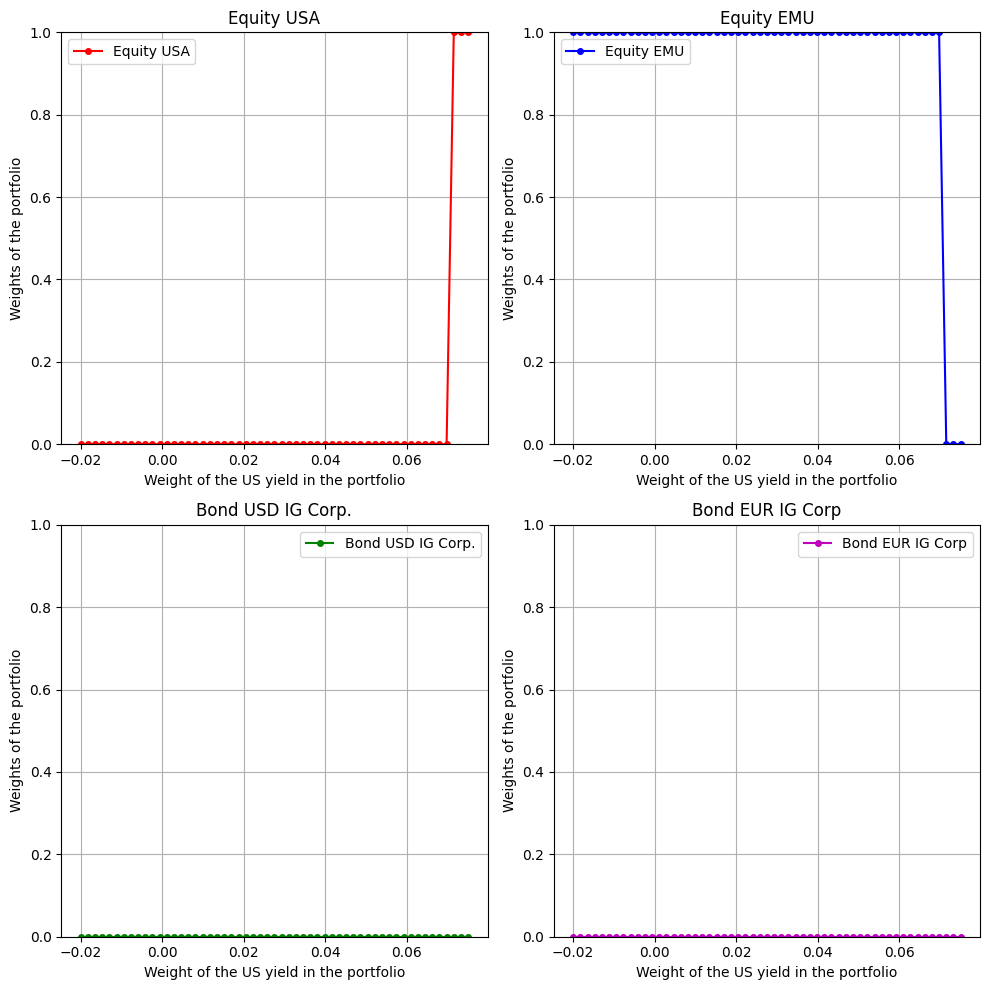

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# How to do a np.linspace avec un step de 0.1 ?
mu_USA = np.linspace(-0.02,0.075,55) # 55 is to get a space of 0.001
mu_portfolio = []
for USA in mu_USA:
  mu = np.array([USA, 0.0706, 0.0038, 0.0041])

  w = cp.Variable(n)

  # Define the objective function: maximize returns
  objective = cp.Maximize(mu.T @ w)

  # Define the constraints
  constraints = [
      w >= 0, # Positive constraint
      cp.sum(w) == 1 # Full investment constraint
  ]

  # Define and solve the problem
  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  # Output the results
  mu_portfolio.append(w.value)

mu_portfolio_df = pd.DataFrame(mu_portfolio)
names = ['Equity USA', 'Equity EMU', 'Bond USD IG Corp.', 'Bond EUR IG Corp']
color = ['r', 'b', 'g', 'm']
fig, ax = plt.subplots(2,2, figsize=(10,10))
for i in range(n):
  row = i // 2
  col = i % 2
  ax[row,col].plot(mu_USA, mu_portfolio_df[i], marker='o', linestyle='-', color = color[i], markersize=4, label=names[i])
  ax[row, col].set_xlabel('Weight of the US yield in the portfolio')
  ax[row, col].set_ylabel('Weights of the portfolio')
  ax[row, col].set_title(names[i])
  ax[row, col].grid(True)
  ax[row, col].legend()
  ax[row,col].set_ylim(0,1)
plt.tight_layout()
plt.show()

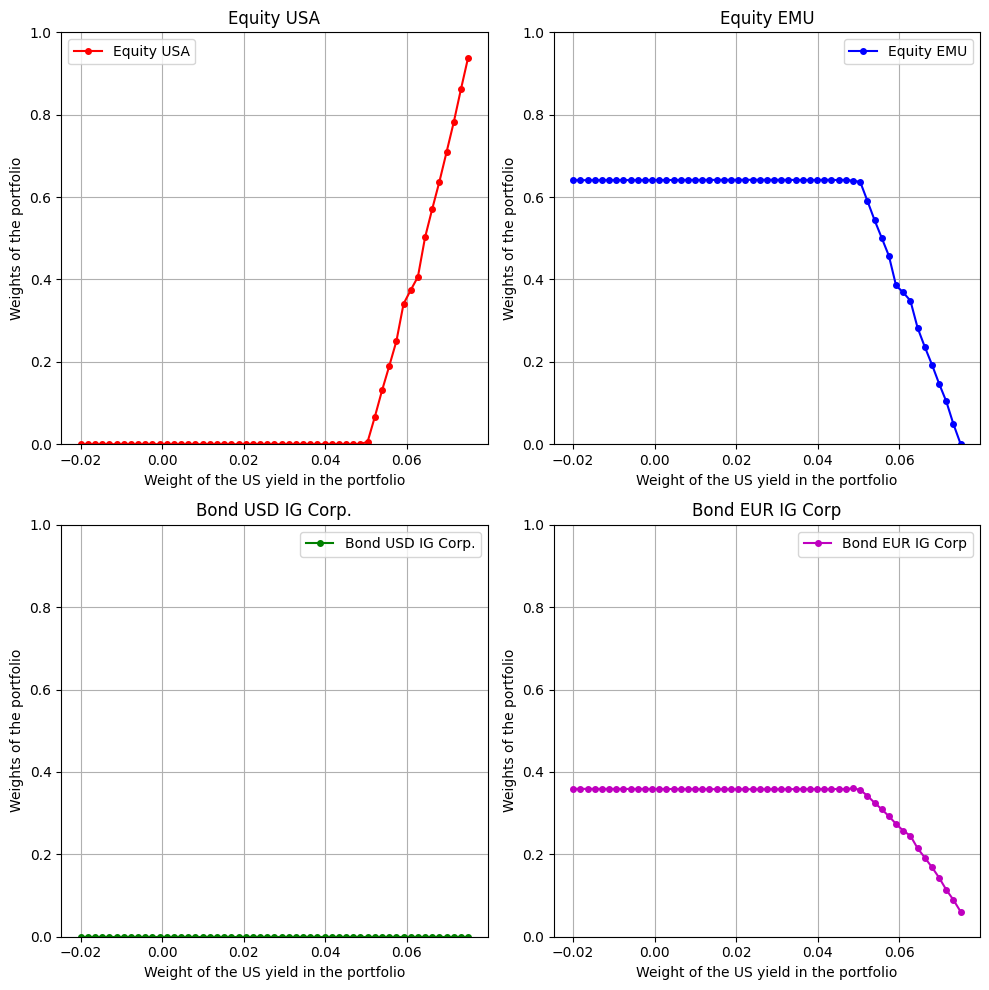

In [ ]:
mu_portfolio_rob = []
kappa = 0.25
for USA in mu_USA:
  mu = np.array([USA, 0.0706, 0.0038, 0.0041])

  def objective_function(w):
    return -(mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Omega @ w)

  def constraint_sum_to_one(w):
      return np.sum(w) - 1

  def constraint_non_negative(w):
      return w

  # Initial guess for weights (e.g., equally weighted)
  w0 = np.ones(n) / n

  # Constraints definition for scipy.optimize.minimize
  constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                  {'type': 'ineq', 'fun': constraint_non_negative})

  # Bounds for weights (0 to 1, inclusive)
  bounds = [(0, 1) for _ in range(n)]

  # Optimization
  result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

  if result.success:
      w_rob = result.x
      mu_portfolio_rob.append(w_rob)

mu_portfolio_rob_df = pd.DataFrame(mu_portfolio_rob)
names = ['Equity USA', 'Equity EMU', 'Bond USD IG Corp.', 'Bond EUR IG Corp']
color = ['r', 'b', 'g', 'm']
fig, ax = plt.subplots(2,2, figsize=(10,10))
for i in range(n):
  row = i // 2
  col = i % 2
  ax[row,col].plot(mu_USA, mu_portfolio_rob_df[i], marker='o', linestyle='-', color = color[i], markersize=4, label=names[i])
  ax[row, col].set_xlabel('Weight of the US yield in the portfolio')
  ax[row, col].set_ylabel('Weights of the portfolio')
  ax[row, col].set_title(names[i])
  ax[row, col].grid(True)
  ax[row, col].legend()
  ax[row,col].set_ylim(0,1)
plt.tight_layout()
plt.show()

The robust optimization has a better reaction to perturbations on the US yields than the Markowitz one.

#### Exercise 4 : $\Omega$

First with $\Omega = diag(\Sigma)$

In [ ]:
# Let's define the parameters :
mu = np.array([0.0548, 0.0706, 0.0038, 0.0041])
lamb = 2
kappa = 0.25
sigma = np.array([0.143, 0.164, 0.083, 0.07])
rho = np.array([[1, 0.821, 0.285, 0.06],
               [0.821,1,0.344,0.017],
               [0.285, 0.344, 1, 0.589],
               [0.06,0.017,0.589,1]])
D = np.diag(sigma)
Omega = np.diag(np.diag(D @ rho @ D))

In [ ]:
def objective_function(w):
    return -(mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Sigma @ w)

def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_non_negative(w):
    return w

# Initial guess for weights (e.g., equally weighted)
w0 = np.ones(n) / n

# Constraints definition for scipy.optimize.minimize
constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                {'type': 'ineq', 'fun': constraint_non_negative})

# Bounds for weights (0 to 1, inclusive)
bounds = [(0, 1) for _ in range(n)]

# Optimization
result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

# Print results
if result.success:
    w_rob = result.x
    print("Optimal weights w_rob:", np.round(w_rob,2))
    print("Maximum expected return:", np.round(mu.T @ w_rob * 100, 2), "%")
    print("Portfolio variance:", np.round(w_rob.T @ Omega @ w_rob,2))
else:
    print("Optimization failed:", result.message)

Optimal weights w_rob: [0.4  0.44 0.   0.16]
Maximum expected return: 5.34 %
Portfolio variance: 0.01


In [ ]:
# For the minimum variance portfolio with the matrix Omega updated :
import cvxpy as cp
w = cp.Variable(n)
objective = cp.Minimize(w.T @ Omega @ w)

one = np.ones(n)

# Define the constraints
constraints = [
    one.T @ w == 1
]

# Define and solve the problem
prob = cp.Problem(objective, constraints)
result = prob.solve()

# Output the results
print("Optimal weights w_MVO:", w.value)
print("Minimum variance:", result)

Optimal weights w_MVO: [0.11233532 0.08540842 0.33345115 0.4688051 ]
Minimum variance: 0.0022971449928335646


In [ ]:
kappa = [1,10,100,1000,10000]
for k in kappa:
  def objective_function(w):
      return -(mu.T @ w - k * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Sigma @ w)

  def constraint_sum_to_one(w):
      return np.sum(w) - 1

  def constraint_non_negative(w):
      return w

  # Initial guess for weights (e.g., equally weighted)
  w0 = np.ones(n) / n

  # Constraints definition for scipy.optimize.minimize
  constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                  {'type': 'ineq', 'fun': constraint_non_negative})

  # Bounds for weights (0 to 1, inclusive)
  bounds = [(0, 1) for _ in range(n)]

  # Optimization
  result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

  # Print results
  if result.success:
      w_rob = result.x
      print("For kappa =",k)
      print("Optimal weights w_rob:", w_rob)
      print("The difference with the minimum variance portfolio is:",w_rob-[0.11233532, 0.08540842, 0.33345115,  0.4688051])
  else:
      print("Optimization failed:", result.message)

For kappa = 1
Optimal weights w_rob: [0.19293855 0.17299092 0.24758347 0.38648706]
The difference with the minimum variance portfolio is: [ 0.08060323  0.0875825  -0.08586768 -0.08231804]
For kappa = 10
Optimal weights w_rob: [0.12101059 0.09451989 0.3249464  0.45952312]
The difference with the minimum variance portfolio is: [ 0.00867527  0.00911147 -0.00850475 -0.00928198]
For kappa = 100
Optimal weights w_rob: [0.11320649 0.08633057 0.33260039 0.46786255]
The difference with the minimum variance portfolio is: [ 0.00087117  0.00092215 -0.00085076 -0.00094255]
For kappa = 1000
Optimal weights w_rob: [0.11241514 0.08549744 0.33340669 0.46868072]
The difference with the minimum variance portfolio is: [ 7.98232699e-05  8.90243757e-05 -4.44567092e-05 -1.24380936e-04]
For kappa = 10000
Optimal weights w_rob: [0.1123421  0.08541533 0.33343978 0.46880278]
The difference with the minimum variance portfolio is: [ 6.78496393e-06  6.91238760e-06 -1.13663389e-05 -2.32101263e-06]


Therefore, the robust optimization porfolio converges to the minimum variance portfolio associated, with the relevant $\Omega$ matrix associated, when $\kappa \rightarrow +\infty$.

Next, let's consider $\Omega = \mathbb{I}$

In [ ]:
# Let's define the parameters :
mu = np.array([0.0548, 0.0706, 0.0038, 0.0041])
lamb = 2
kappa = 0.25
sigma = np.array([0.143, 0.164, 0.083, 0.07])
rho = np.array([[1, 0.821, 0.285, 0.06],
               [0.821,1,0.344,0.017],
               [0.285, 0.344, 1, 0.589],
               [0.06,0.017,0.589,1]])
D = np.diag(sigma)
Omega = np.eye(n)

In [ ]:
def objective_function(w):
    return -(mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Sigma @ w)

def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_non_negative(w):
    return w

# Initial guess for weights (e.g., equally weighted)
w0 = np.ones(n) / n

# Constraints definition for scipy.optimize.minimize
constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                {'type': 'ineq', 'fun': constraint_non_negative})

# Bounds for weights (0 to 1, inclusive)
bounds = [(0, 1) for _ in range(n)]

# Optimization
result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

# Print results
if result.success:
    w_rob = result.x
    print("Optimal weights w_rob:", np.round(w_rob,2))
    print("Maximum expected return:", np.round(mu.T @ w_rob * 100, 2), "%")
    print("Portfolio variance:", np.round(w_rob.T @ Omega @ w_rob,2))
else:
    print("Optimization failed:", result.message)

Optimal weights w_rob: [0.28 0.3  0.21 0.22]
Maximum expected return: 3.81 %
Portfolio variance: 0.26


In [ ]:
kappa = [1,10,100,1000,10000]
for k in kappa:
  def objective_function(w):
      return -(mu.T @ w - k * np.sqrt(w.T @ Omega @ w) - lamb/2 * w.T @ Sigma @ w)

  def constraint_sum_to_one(w):
      return np.sum(w) - 1

  def constraint_non_negative(w):
      return w

  # Initial guess for weights (e.g., equally weighted)
  w0 = np.ones(n) / n

  # Constraints definition for scipy.optimize.minimize
  constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                  {'type': 'ineq', 'fun': constraint_non_negative})

  # Bounds for weights (0 to 1, inclusive)
  bounds = [(0, 1) for _ in range(n)]

  # Optimization
  result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)

  # Print results
  if result.success:
      w_rob = result.x
      print("For kappa =",k)
      print("Optimal weights w_rob:", w_rob)
      print("The difference with the minimum variance portfolio is:",w_rob-[0.25, 0.25, 0.25, 0.25])
  else:
      print("Optimization failed:", result.message)

For kappa = 1
Optimal weights w_rob: [0.2573115  0.26326027 0.23850536 0.24092287]
The difference with the minimum variance portfolio is: [ 0.0073115   0.01326027 -0.01149464 -0.00907713]
For kappa = 10
Optimal weights w_rob: [0.25074382 0.25134901 0.24883062 0.24907656]
The difference with the minimum variance portfolio is: [ 0.00074382  0.00134901 -0.00116938 -0.00092344]
For kappa = 100
Optimal weights w_rob: [0.25007452 0.25013516 0.24988284 0.24990748]
The difference with the minimum variance portfolio is: [ 7.45231136e-05  1.35157057e-04 -1.17161383e-04 -9.25187874e-05]
For kappa = 1000
Optimal weights w_rob: [0.25000745 0.25001352 0.24998828 0.24999075]
The difference with the minimum variance portfolio is: [ 7.45450011e-06  1.35176588e-05 -1.17191188e-05 -9.25304011e-06]
For kappa = 10000
Optimal weights w_rob: [0.25000074 0.25000135 0.24999883 0.24999908]
The difference with the minimum variance portfolio is: [ 7.44801541e-07  1.35224214e-06 -1.17214669e-06 -9.24896996e-07]


So the portfolio tends to the equally weighted portfolio when $\kappa \rightarrow +\infty$

If the variance-covariance matrix $\Sigma$ is badly estimated, the choice $\Omega = diag(\Sigma)$ is better as it offers a great trade-off between robustness and performance.